# SLOPE for Count Data

*Authors: Zachary Lau, Joey Hotz and Javier Martinez-Rodriguez*

## Introduction

Sorted L-One Penalized Estimation (SLOPE) is a regularization method for estimating the coefficients of a regression model which is an extension of the LASSO regression model. SLOPE is a particularly attractive choice for variable selection and regularization for data where $p \gg n$, which makes this method quite useful for fields such as genetics.

The SLOPE estimator is characterized  by the penalization term $\sum_{i=1}^{p}\lambda_{i}\left|\beta\right|_{(i)}$. In this penalty equation, the estimated coefficients are sorted in order of magnitude, with $|\beta|_{(1)} \ge |\beta|_{(2)} \ge \cdots \ge |\beta|_{(p)}$, and the corresponding penalty parameters form a non-increasing sequence, with $\lambda_{1} \ge \lambda_{2} \ge \cdots \ge \lambda_{p}$ (Bogdan et al. 2015). SLOPE regularization offers finite-sample guarantees for the coefficients selected by the model. In particular, SLOPE with sequence of $\lambda_{i}$'s inspired by the Benjamini-Hochberg (BH) procedure is proven to provide control over the false discovery rate (FDR) for Gaussian linear models (Bogdan et al. 2015).

However, the efficacy of SLOPE regression has not been thoroughly discussed or investigated in the context of generalized linear models (GLMs) such as Poisson regression. This project aims to empirically evaluate the variable selection performed by SLOPE and to compare the performance of SLOPE to LASSO and Adaptive LASSO for variable selection. The central research question tackled in this report is the following: 

> **How does the performance of SLOPE regarding variable selection accuracy (FDR and power) compare to LASSO and Adaptive LASSO when applied to high-dimensional Poisson regression?**

To address this central question, we employ simulations to compare the accuracy of variable selection (measured by FDR and power) of SLOPE against the standard and Adaptive LASSO estimators in several different experiments. These experiments vary in the dimensionality of the predictors (ratio of $p/n$), the inter-predictor correlation ($\\rho$) and the sparsity ($k$).

This document is organized into three parts: First, we provide a general background and explanation of SLOPE for multivariate linear regression models, and the effect of choosing different procedures such as the Benjamini-Hochberg to determine the penalty parameters, as discussed by Bogdan et al. (2015). Second, we adress the implementation of SLOPE for generalized linear models – particularly those with count data – as proposed by Larsson et al. (2024).  In the third section, we discuss the simulation methodology, alternative penalizations to SLOPE, and discuss the results of the simulations.


## Methods and Results

### The SLOPE Estimator

SLOPE extends the LASSO penalty by replacing the single penalty parameter $\lambda$ with a non-increasing sequence of regularization parameters $\{\lambda_{i}\}_{i=1}^{p}$, which results in the SLOPE optimization problem
$$\min \frac 1 2 \|y-X\beta\|^2 + \sigma \cdot \sum_{i=1}^p \lambda_{i} |\beta|_{(i)}$$

In this penalty equation, the estimated coefficients are sorted in order of magnitude, with $|\beta|_{(1)} \ge |\beta|_{(2)} \ge \cdots \ge |\beta|_{(p)}$, and the corresponding penalty parameters form a non-increasing sequence, with $\lambda_{1} \ge \lambda_{2} \ge \cdots \ge \lambda_{p} \ge 0$ (Bogdan et al. 2015, 1109). SLOPE reduces to LASSO when $\lambda_{1} = \lambda_{2} = \cdots = \lambda_{p} > 0$, and SLOPE to OLS when each $\lambda_{i}$ is identically zero. 

### Model Selection with SLOPE

Unlike the LASSO estimator (Tibshirani, 1996), which has a common penalization term shared among all coefficients, SLOPE applies larger penalties to the coefficients with larger magnitudes. This decision is motivated to provide finite sample guarantees for the model selected via SLOPE. As described by Bogdan et al. (2015), variable selection for a statistical model is akin to simultaneously testing many null hypotheses of the form $H_{0j}: \beta_{j} = 0$. 

Under an orthogonal design ($\mathbf{X}^{\top}\mathbf{X} = \mathbb{I}_{p \times p}$), using LASSO for variable selection weakly controls the family-wise error rate (FWER) at a prescribed level $\alpha \in (0, 1)$ by setting $\lambda = \sigma\Phi^{-1}(1 - \frac{\alpha}{2p})$ (Abramovich, Grinshtein and Pensky 2007). Instead of controlling the FWER, the SLOPE estimator is designed to control the false discovery rate (FDR) under an orthogonal design. 

In order to control the FDR, the authors propose choosing the sequence $\{\lambda_{i}\}_{i=1}^{p}$ based on the critical values for the Benjamini-Hochberg procedure, which solidifies the connection between SLOPE and the FDR. For an MLR model with an orthogonal design, these values are:
$$\lambda_i = \sigma \Phi^{-1}\left(1 - \frac{q \cdot i}{2p}\right),$$
where $\sigma$ is the noise/standard deviation (assumed to be known), $\Phi^{-1}$ is the quantile function for a standard Normal distribution, $q$ is the desired FDR, $p$ is the number of predictors, and $i$ is the index/rank. 

### Explanation of SLOPE for Count Data

In this section, we partially extend the theory of SLOPE to the case of GLMs. In particular, we focus on finding the analogous Benjamini-Hochberg coefficients for a generalized linear model, with an emphasis on Poisson regression models. Although Larsson et al. (2024) provide an implementation of SLOPE for Poisson and logistic regression models, their implementation simply uses the BH coefficients derived by Bogdan et al. (2015) for the Gaussian model.

Recall that the density of an exponential family model is $$ f(y; \phi, \eta) = \exp\left(\frac{y\eta - b(\eta)}{a(\phi)}+c(y,\phi)\right)$$

For a GLM with the canonical link, we have that $\eta = \mathbf{X}^\top\beta$. As such: 
$$f(y; X, \beta) = \exp\left(\frac{y\mathbf{X}^\top\beta - b(\mathbf{X}^\top \beta)}{a(\phi)}+c(y,\phi)\right)$$

In such cases, we can numerically find the MLE $\hat{\beta}$ for the specified model. Under appropriate regularity conditions, $\hat{\beta}$ is known to have an asymptotic distribution $$ \sqrt{n}(\hat\beta-\beta) \leadsto \mathcal N(0, \mathcal I^{-1}(\beta)),$$
where $\mathcal{I}(\beta)$ is the expected Fisher information. For an exponential family with the canonical link, $\mathcal{I}(\beta) = \frac{1}{a(\phi)}\mathbf{X}^{\top}\textrm{diag}\left(b''(\mathbf{X}^{\top}\beta)\right)\mathbf{X}$.

### BH-Inspired Coefficients for the Poisson GLM

To extend the SLOPE estimator to count data, we focus on two simplifications:

1. As done by Bogdan et al. (2015) in their seminal paper on SLOPE, we assume that the design matrix $\mathbf{X}$ is orthogonal.
2. We consider the distribution under the "omnibus null hypothesis": ${\beta} = \vec{\mathbf{0}}$.

Under these two simplifications, we find that 

$$\mathcal I(\beta) = \frac{b''(0)}{a(\phi)}\mathbb{I}_{p \times p}.$$

Thus, under the omnibus null hypothesis $H_{0}: {\beta} = \vec{\mathbf{0}}$, the coefficient estimates $H0: \beta = \vec 0$, the coefficient estimates $\hat{\beta}_{i}$ are all independently, identically distributed with mean zero and variance $\frac{a(\phi)}{b''(0)}$. 

For the Poisson GLM in particular, we have that $a(\phi) = 1$ and $b''(0) = 1$, which implies that $\sqrt{n}(\hat{\beta}_{i} - \beta_{i})$ asymptotically converges in distribution to a standard Normal distribution under the two assumptions above.

Applying the Benjamini-Hochberg method as done in Bogdan et al. (2015), this gives BH-inspired SLOPE coefficients of the form
$$\lambda_j = \sqrt{\frac{a(\phi)}{nb''(0)}}\Phi^{-1}\left(1-\frac{qj}{2m}\right)$$

For the Poisson GLM with the canonical link function, this simplifies to $$\lambda_j = \frac{1}{\sqrt{n}}\Phi^{-1}\left(1-\frac{qj}{2m}\right)$$

These differ by a constant factor of $\frac{1}{\sqrt{n}}$ from the coefficients used in Larsson et al. (2024).

### Validity of the Assumptions

We return to the second assumption mentioned above (${\beta} = \vec{\mathbf{0}}$). This assumption is not exactly valid in a practical setting, as not all of the null hypotheses will be true.

This is not problematic if the estimated coefficients are uncorrelated. For example, if $b''(\eta)$ is a constant function – which occurs in multiple linear regression – then this may not violate the FDR-controlling purpose of SLOPE. However, if the mean and variance of the model are related to one another, as they are in Poisson and logistic regression models, this simplification is not applicable. In such cases, we have that 
$$ \mathcal I(\beta)_{jk} = \frac{1}{a(\phi)}\sum_{i=1}^n b''(\eta_i) \mathbf{X}_{ij}\mathbf{X}_{ik}$$

Under the assumption that the design matrix is orthogonal, $\sum_{i=1}^n x_{ij}x_{ik} = 0$ for $j \neq k$. However, when the factor $b''(\eta_i)$ is dependent on $\mathbf{X}_i$, we can no longer use this identity. Not only does this lead to correlation between coefficient estimates for the active and inactive predictors, but the matrix inversion operation can even induce correlation among the estimates for two inactive predictors! 

Thus, we can expect that the theoretical guarantees for SLOPE with multiple linear regression models hold best when the diagonal matrix of second derivatives is near-constant. This phenomenon occurs when there is a weak signal, and when the models are sparse.

Another issue with this assumption is that there is no intercept. This is not typically an issue for linear models, because the reponse can be centered.
However, count responses cannot reliably be centered, so there is almost certainly a true non-zero intercept for the specified GLM. Our weak signal model then yields $$\lambda_j = \sqrt{\frac{a(\phi)}{nb''(\beta_0)}}\phi^{-1}\left(1-\frac{qj}{2m}\right)$$

Unfortunately, $\beta_0$ is typically estimated jointly with the other coefficients. As such, it cannot be separately estimated to choose appropriate values for the sequence $\{\lambda_{i}\}_{i=1}^{p}$. One solution is to use cross-validation to choose a proportionality constant, as done by Larsson et al (2024). However, this is not a perfect fix, as cross-validation evaluates predictive accuracy, whereas SLOPE is designed for inference, making this approach theoretically unsatisfying. 

Further issues to discuss with the Poisson GLM include overdispersion and the small-sample case.

### Experiments

#### Competing Penalizations

The LASSO penalty is defined as $\lambda \|\boldsymbol{\beta}\|_1 = \lambda \sum_{j=1}^{p} |\beta_j|$, where $\lambda \ge 0$ is a single tuning parameter that regulates the strength of the penalty (Tibshirani 1996). As previously discussed, Bonferroni-inspired penalization of LASSO provides control over FWER. however, this extension does not apply to non-Gaussian GLMs. For this reason, our project only compares LASSO tuned through cross-validation.

The Adaptive LASSO, proposed by Zou (2006), modifies the standard LASSO penalty by incorporating adaptive weights for each coefficient $\lambda \sum_{j=1}^{p} w_j |\hat{\beta}_j|$. These weights $w_j$ are determined from an initial consistent estimate of the coefficients $w_j \propto 1/|\hat{\beta}_{init, j}|^{-\gamma}$. The motivation for these weights is to assign smaller penalties to coefficients with large initial estimates while imposing larger penalties on those with smaller initial estimates.

Due to its design, Zou (2006, 1424) showed that the oracle properties of Adaptive LASSO can be extended to GLMs under mild regularity conditions. This indicates that the estimator asymptotically behaves as if the true underlying model is known in advance, this method correct identification of the true set of non-zero coefficients with a probability approaching 1 as the sample size $n \rightarrow \infty$. Consequently, this method serves as a benchmark for comparing the variable selection capabilities of Poisson SLOPE.

Other methodologies, including Data Splitting, Multiple Data Splitting (MDS), model-X knockoff, and Gaussian mirror have been shown to effectively control FDR for GLMs. However, these approaches will not be addressed in this project. 


#### Experimental Settings

To compare the variable selection performance of SLOPE against LASSO and Adaptive LASSO for high-dimensional data, count data is generated following a Poisson distribution with a log-linear link given by $\log(\lambda_i) = \beta_0 + X_i \beta$. The comparison is measured in terms of FDR and Power across 50 replications to ensure statistical stability. Performance is assessed using SLOPE tuned to a target FDR of $q=0.05$ via a BH-inspired $\lambda$ sequence, while LASSO and Adaptive LASSO tune $\lambda$ using 10-fold cross-validation minimizing Poisson deviance.

The chosen experimental settings are conditions to challenge variable selection. The dimensionality cases include scenarios where predictors outnumber observations, are equal and are fewer ($p \in \{500, 1000, 2000\}$ with $n=1000$). Predictor correlation is evaluated with none, medium, and high correlation ($\rho \in \{0, 0.5, 0.8\}$). This is particularly relevant since correlation among regressors introduces complications in the selection of variables.

The underlying sparsity level ($k \in \{10, 20, 50, 100\}$ active predictors) is evaluated at different levels to see how methods cope as the number of true signals increases relative to the total predictors. Finally, the experiments focus on cases with weak signal strenght. The code below implements the generative model for the discussed settings. 

In [ ]:
# Setup ----
## Packages to use ----
if (!require("pacman")) install.packages("pacman")
# if (!require("mytidyfunctions")) remotes::install_github("JavierMtzRdz/mytidyfunctions")

pacman::p_load(tidyverse, janitor, 
               SLOPE, glmnet, MASS,
              # mytidyfunctions,
               progress,
               patchwork, here)

## Load fonts ----
extrafont::loadfonts(quiet = TRUE)

## Set theme ------
# mytidyfunctions::set_mytheme(text = element_text(family = "Lato"))


In [ ]:
# Generative models
## Simulation Parameters
n <- 1000         
p_values <- c(2000) 
rho_values <- c(0)  
k_values <- c(10, 20, 50, 100) # Non-zero betas
signal_strengths <- list( 
  weak = list(beta_min = 0.1, beta_max = 0.5)
  #strong = list(beta_min = 0.5, beta_max = 1.5)
)
R <- 30
q_fdr <- 0.05       # q parameter for SLOPE
adapt_lasso_gamma <- 1 # ALasso weights
beta0 <- 0.1
alpha <- 1


## Generative model
generate_data <- function(n, p, rho, k, signal_info, beta0) {

  beta_true <- numeric(p)

  if (k > 0) {
    non_zero_indices <- sample(1:p, k)
    magnitudes <- runif(k, min = signal_info$beta_min, max = signal_info$beta_max)
    signs <- sample(c(-1, 1), k, replace = TRUE)
    beta_true[non_zero_indices] <- magnitudes * signs
  }
  true_support <- which(beta_true != 0)

  # Generate X
  Sigma <- matrix(rho, nrow = p, ncol = p)
  diag(Sigma) <- 1
  X <- MASS::mvrnorm(n = n, mu = rep(0, p), Sigma = Sigma)
  X <- scale(X)

  # Count response 
  lambda <- exp(beta0 + X %*% beta_true)
  # lambda <- pmin(lambda, some_large_value)
  y <- rpois(n, lambda)

  return(list(X = X, y = y, beta_true = beta_true, true_support = true_support, beta0 = beta0, lambda = lambda))
}

In [217]:
# Function to calculate FDR and Power
calculate_metrics <- function(selected_indices, true_indices, p) {
  true_positives <- length(intersect(selected_indices, true_indices))
  false_positives <- length(setdiff(selected_indices, true_indices))
  # Power
  power <- ifelse(length(true_indices) == 0, NA, true_positives / length(true_indices))
  # FDR
  fdr <- ifelse((true_positives + false_positives) == 0, 0, false_positives / (true_positives + false_positives))
  return(list(FDR = fdr, Power = power, TP = true_positives, FP = false_positives, Selected_Count = length(selected_indices)))
}

In [ ]:
# Loop ---
results_list <- list()
total_runs <- length(p_values) * length(rho_values) * length(k_values) * length(signal_strengths) * R
cli::cli_progress_bar("Cleaning data", total = total_runs)
iter <- 0

set.seed(538)

for (p in p_values) {
  for (rho in rho_values) {
    for (k in k_values) {
      for (signal_name in names(signal_strengths)) {
        signal_info <- signal_strengths[[signal_name]]
        for (rep in 1:R) {
          cli::cli_progress_update()
          iter <- iter + 1

          # Generate Data
          sim_data <- generate_data(n = n, p = p, rho = rho, k = k,
                                    signal_info = signal_info, beta0 = beta0)
          X <- sim_data$X
          y <- sim_data$y
          lambda_val <- sim_data$lambda
          true_support <- sim_data$true_support # Indices of non-zero elements in beta_true
          # Models

          # SLOPE
          selected_slope <- integer(0) # Initialize as empty
          fdr_slope <- NA
          power_slope <- NA
          slope_error <- FALSE
          slope_fit <- SLOPE::SLOPE(X, y, family = "poisson", q = q_fdr, lambda = "gaussian", alpha = sqrt(exp(beta0)/n)+0.01,
          max_passes = 5000)
          slope_coeffs <- coef(slope_fit)

          selected_slope <- which(abs(slope_coeffs[-1]) > 1e-6)
          metrics_slope <- calculate_metrics(selected_slope, true_support, p)
          fdr_slope <- metrics_slope$FDR
          power_slope <- metrics_slope$Power

          cli::cli_inform("SLOPE finished")

          # SLOPE CV
          #selected_slope_cv <- integer(0) # Initialize as empty
          #fdr_slope_cv <- NA
          #power_slope_cv <- NA
          #slope_cv_error <- FALSE
          #slope_cv_fit <- SLOPE::SLOPE(X, y, family = "poisson", q = q_fdr, lambda = "gaussian", alpha = sqrt(exp(beta0)/n)+0.02,
          #max_passes = 5000)
          #slope_cv_coeffs <- coef(slope_cv_fit)
          #selected_slope_cv <- which(abs(slope_cv_coeffs[-1]) > 1e-6)
          #metrics_slope <- calculate_metrics(selected_slope_cv, true_support, p)
          #fdr_slope_cv <- metrics_slope$FDR
          #power_slope_cv <- metrics_slope$Power

          #cli::cli_inform("SLOPE CV finished")

          # LASSO 
          selected_lasso <- integer(0)
          fdr_lasso <- NA
          power_lasso <- NA
          lasso_error <- FALSE
          cv_lasso_fit <- cv.glmnet(X, y, family = "poisson", alpha = 1, standardize = FALSE)
          lasso_coeffs <- coef(cv_lasso_fit, s = "lambda.min")
          selected_lasso <- which(lasso_coeffs[-1] != 0) 
          metrics_lasso <- calculate_metrics(selected_lasso, true_support, p)
          fdr_lasso <- metrics_lasso$FDR
          power_lasso <- metrics_lasso$Power
          cli::cli_inform("LASSO finished")

          # Adaptive LASSO
          selected_adapt <- integer(0)
          fdr_adapt <- NA
          power_adapt <- NA
          adapt_error <- FALSE

          cv_ridge_fit <- cv.glmnet(X, y, family = "poisson", alpha = 0, standardize = FALSE) 
          ridge_coeffs <- coef(cv_ridge_fit, s = "lambda.min")[-1] 

          # Calculate weights 
          weights <- 1 / (abs(ridge_coeffs) + .Machine$double.eps)^adapt_lasso_gamma
          weights <- pmin(weights, 1e10) 

          # Fit weighted LASSO using CV
          cv_adapt_fit <- cv.glmnet(X, y, family = "poisson", alpha = 1,
                                      penalty.factor = weights, standardize = FALSE)
          adapt_coeffs <- coef(cv_adapt_fit, s = "lambda.min")
          selected_adapt <- which(adapt_coeffs[-1] != 0) 
      
          metrics_adapt <- calculate_metrics(selected_adapt, true_support, p)
          fdr_adapt <- metrics_adapt$FDR
          power_adapt <- metrics_adapt$Power

          cli::cli_inform("ALASSO finished")

          # Save results
          results_list[[iter]] <- data.frame(
            n = n, p = p, rho = rho, k = k, signal = signal_name, replication = rep,
            Method = c("SLOPE", "LASSO", "AdaptiveLASSO"),
            FDR = c(fdr_slope, fdr_lasso, fdr_adapt),
            Power = c(power_slope, power_lasso, power_adapt),
            SelectedCount = c(length(selected_slope), length(selected_lasso), length(selected_adapt),
          metrics = c(metrics_slope, metrics_lasso, metrics_adapt))
          )
          write_rds(results_list[[iter]], here("data-prcssd", paste0("results-", iter, ".rds")))
          cli::cli_inform("Iteration {iter}/{total_runs} finished\n\n {results_list[[iter]]}")

        }}}}} 
cli::cli_progress_done()

final_results <- bind_rows(results_list)

In [269]:
# Extract results from local docs
list_results <- list.files(here::here("data-prcssd"), "rds")

results_list <- map(list_results, ~readRDS(here::here("data-prcssd", .x)))

final_results <- bind_rows(results_list) 

## Discussion

The plots generated from the simulation study show the comparative performances of SLOPE, LASSO, and Adaptive LASSO in terms of FDR and Power for variable selection using Poisson regression. Despite variations across different dimensional settings ($p=500, 1000, 2000$ while $n=1000$), the plots had consistent patterns across these scenarios.

In general, SLOPE consistently had better control over false discoveries, achieving the lowest FDR among the three methods under high sparsity conditions (low number of true non-zero variables, $k \le 25$) across all tested levels of predictor correlation ($\rho = 0, 0.5, 0.8$). In those cases, SLOPE's FDR remained below 0.5. Conversely, standard LASSO displayed the highest FDR as expected. Meanwhile, Adaptive LASSO offered intermediate FDR control. Interestingly, with an increase in the number of true non-zero variables (larger $k$), the FDR levels of all three methods tended to converge somewhat.

However, the enhanced FDR control exhibited by SLOPE came at the cost of statistical Power. The simulation plots indicated that LASSO generally achieved the highest Power, especially when the true model was sparse (low $k$). Adaptive LASSO followed closely, displaying slightly lower Power compared to LASSO. In contrast, SLOPE had lower Power than both LASSO variants when predictor correlations were high ($\rho=0.5, 0.8$). Notably, SLOPE's Power was similar to the other methods when the predictors were uncorrelated ($\rho=0$). Furthermore, as the number of true signals increased ($k=100$), while LASSO's and particularly Adaptive LASSO's Power diminished, SLOPE managed to maintain its Power. Consequently, at $k=100$, SLOPE's Power surpassed that of the other methods while sustaining comparable FDR control.

In conclusion, the simulation results highlight SLOPE's effectiveness in variable selection for count data settings. It provides better control over the False Discovery Rate in comparison to LASSO and Adaptive LASSO, particularly in cases of high sparsity. Therefore, the choice of method should be made with careful consideration of the specific analysis objectives. 



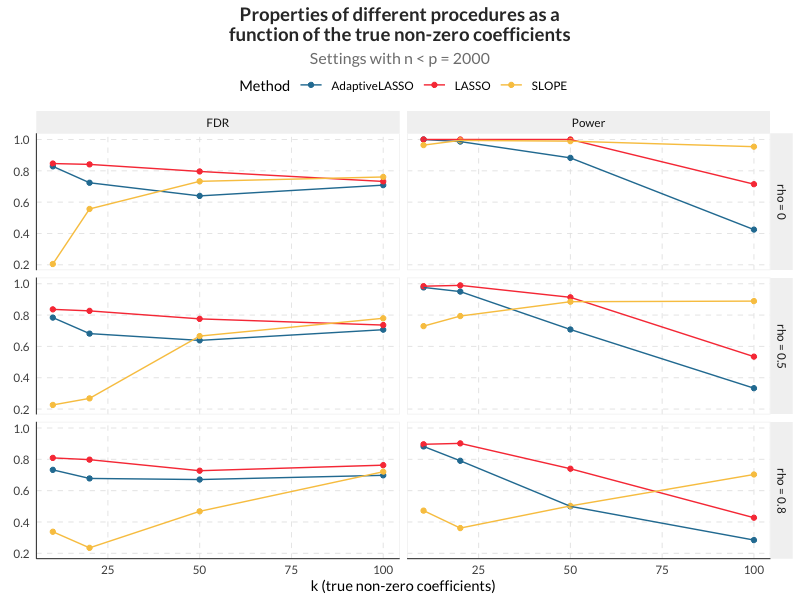

In [270]:
final_results %>% 
  filter(signal == "weak", p == 2000) %>% 
  pivot_longer(c(FDR, Power)) %>% 
  ggplot(aes(x = k, y = value, color = Method, group = paste0(Method, k))) +
  stat_summary(geom = "point", fun.y = "mean", alpha = 1) +
  stat_summary(aes(group = Method), fun = mean, geom = "line") +
  facet_grid((paste0("rho = ", rho))~name) +
  labs(title = "Properties of different procedures as a\nfunction of the true non-zero coefficients",
subtitle = "Settings with n < p = 2000", 
y = element_blank(),
x = "k (true non-zero coefficients)")

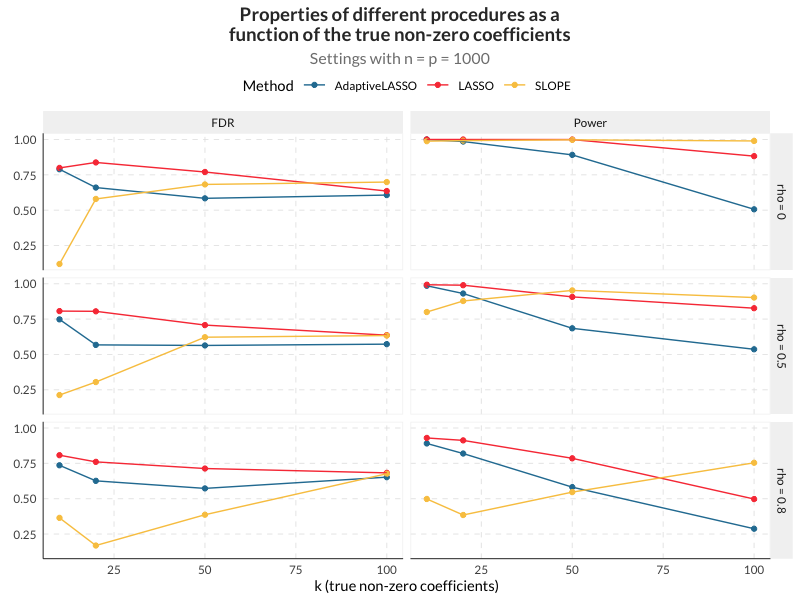

In [271]:
final_results %>% 
  filter(signal == "weak", p == 1000) %>% 
  pivot_longer(c(FDR, Power)) %>% 
  ggplot(aes(x = k, y = value, color = Method, group = paste0(Method, k))) +
  stat_summary(geom = "point", fun.y = "mean", alpha = 1) +
  stat_summary(aes(group = Method), fun = mean, geom = "line") +
  facet_grid((paste0("rho = ", rho))~name) +
  labs(title = "Properties of different procedures as a\nfunction of the true non-zero coefficients",
subtitle = "Settings with n = p = 1000", 
y = element_blank(),
x = "k (true non-zero coefficients)")

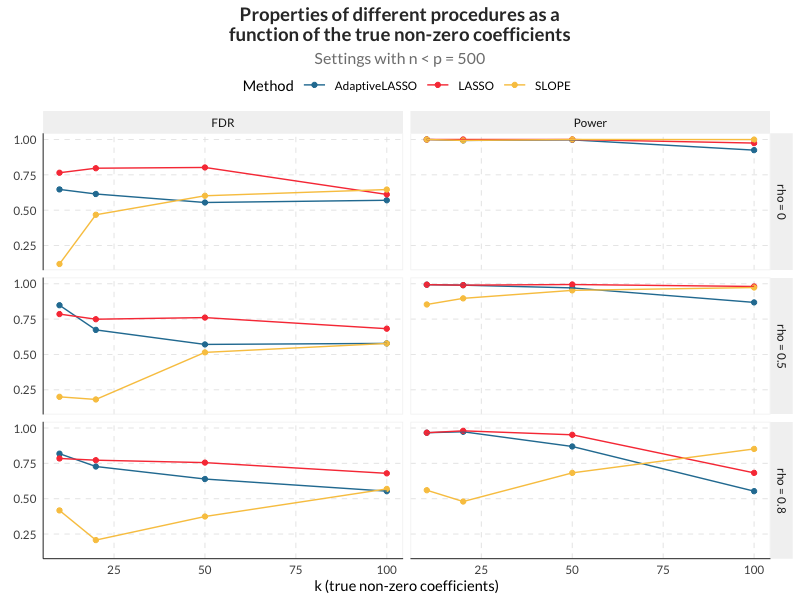

In [272]:
final_results %>% 
  filter(signal == "weak", p == 500) %>% 
  pivot_longer(c(FDR, Power)) %>% 
  ggplot(aes(x = k, y = value, color = Method, group = paste0(Method, k))) +
  stat_summary(geom = "point", fun.y = "mean", alpha = 1) +
  stat_summary(aes(group = Method), fun = mean, geom = "line") +
  facet_grid((paste0("rho = ", rho))~name) +
  labs(title = "Properties of different procedures as a\nfunction of the true non-zero coefficients",
subtitle = "Settings with n < p = 500", 
y = element_blank(),
x = "k (true non-zero coefficients)")

## References

Abramovich, Felix, Vadim Grinshtein, and Marianna Pensky. 2007. “On Optimality of Bayesian Testimation in the Normal Means Problem.” The Annals of Statistics 35 (5): 2261–86.

Bogdan, Małgorzata, Ewout van den Berg, Chiara Sabatti, Weijie Su, and Emmanuel J. Candès. 2015. “Slope—Adaptive Variable Selection Via Convex Optimization.” The Annals of Applied Statistics 9 (3): 1103–40.

Larsson, Johan, Jonas Wallin, Malgorzata Bogdan, Ewout van den Berg, Chiara Sabatti, Emmanuel Candes, Evan Patterson, et al. 2024. “SLOPE: Sorted L1 Penalized Estimation.” R. CRAN. https://cran.r-project.org/web/packages/SLOPE/index.html.

Lin, Buyu. 2024. “Problems in Variable Selection: False Discovery Rate Control and Variational Inference,” May. https://nrs.harvard.edu/URN-3:HUL.INSTREPOS:37378822.

Tibshirani, Robert. 1996. “Regression Shrinkage and Selection via the Lasso.” Journal of the Royal Statistical Society. Series B (Methodological) 58 (1): 267–88.

Zou, Hui. 2006. “The Adaptive Lasso and Its Oracle Properties.” Journal of the American Statistical Association 101 (476): 1418–29. https://doi.org/10.1198/016214506000000735.